In [1]:
import xarray as xr
import numpy as np
import os
indir='/home/ccpd/hpcperm/ECE4-DATA/oifs/TL63L31/19900101'
icm = xr.open_dataset(os.path.join(indir, 'check_icmgg.nc'))
icm

<xarray.Dataset> Size: 3MB
Dimensions:       (time: 1, lon: 128, lat: 64, depth: 1, bnds: 2, depth_2: 1,
                   depth_3: 1, depth_4: 1, snow: 5)
Coordinates:
  * time          (time) datetime64[ns] 8B 1990-01-01
  * lon           (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lat           (lat) float64 512B 87.86 85.1 82.31 ... -82.31 -85.1 -87.86
  * depth         (depth) float64 8B 0.0
  * depth_2       (depth_2) float64 8B 7.0
  * depth_3       (depth_3) float64 8B 28.0
  * depth_4       (depth_4) float64 8B 100.0
  * snow          (snow) float64 40B 0.0 1.0 2.0 3.0 4.0
Dimensions without coordinates: bnds
Data variables: (12/65)
    depth_bnds    (depth, bnds) float64 16B ...
    depth_2_bnds  (depth_2, bnds) float64 16B ...
    depth_3_bnds  (depth_3, bnds) float64 16B ...
    depth_4_bnds  (depth_4, bnds) float64 16B ...
    snow_bnds     (snow, bnds) float64 80B ...
    stl1          (time, depth, lat, lon) float32 33kB ...
    ...            ...
    cldiff        (time, lat, lon) float32 33kB ...
    asn           (time, snow, lat, lon) float32 164kB ...
    sd            (time, snow, lat, lon) float32 164kB ...
    tsn           (time, snow, lat, lon) float32 164kB ...
    rsn           (time, snow, lat, lon) float32 164kB ...
    lwcs          (time, snow, lat, lon) float32 164kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Apr 15 13:01:02 2025: cdo --eccodes -f nc setgridtype,r...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

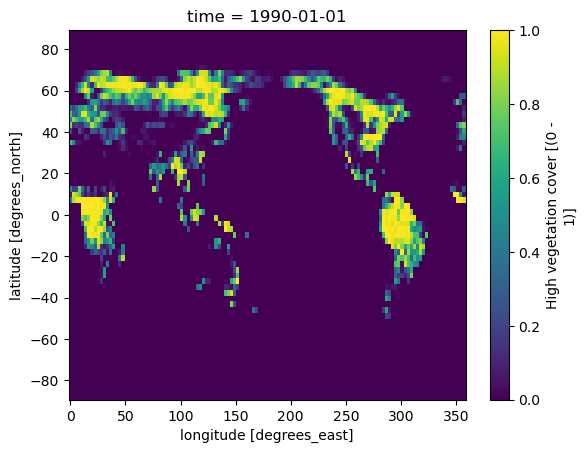

In [21]:
icm['cvh'].plot()

In [ ]:
import numpy as np
import xarray as xr
import os
from utils import modify_single_grib, truncate_grib_file
from cdo import Cdo
cdo = Cdo()
cdo.debug = True


def modify_value(field, var, new_value):
    """
    Modify the Z field in the GRIB file.
    """
    for v in var:
        if v in field.variables:
            print(f"Modifying variable {v} in the field")
            field[v].data = np.full(field[v].shape, new_value)
    return field

indir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101'
climate_indir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/climate.v020'
#outdir='/lus/h2resw01/scratch/ccpd/OIFS-playground'
outdir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/19900101'
climate_outdir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020'
amip_outdir = '/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/amip-forcing'
amip_indir = '/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/amip-forcing'

icefield = xr.open_dataset(os.path.join(amip_indir, 'siconcbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc'))
icefield['siconcbcs'] = icefield['siconcbcs']*0.0
outfile = os.path.join(amip_outdir, 'siconcbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc')
if os.path.exists(outfile):
    os.remove(outfile)
icefield.to_netcdf(outfile)


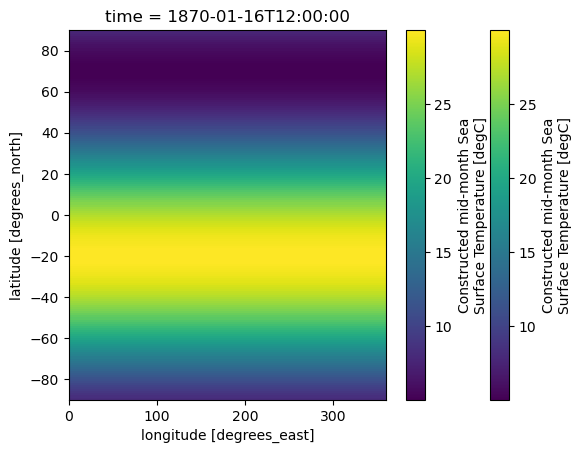

In [ ]:

def generate_seasonal_sst(inputfile, outputfile, A=25, OFFSET=20, T0=5):
    """
    Generate a seasonal SST latitudinal pattern and save it to a netCDF file.
    Parameters:
    - inputfile: Path to the input netCDF file.
    - outputfile: Path to the output netCDF file.
    - A: Amplitude of the latitudinal SST pattern.
    - OFFSET: Phase offset in degree for the seasonal pattern.
    - T0: Mean temperature.
    """

    sstfield = xr.open_dataset(inputfile)
    sstfield['tosbcs'].shape
    lons = sstfield['lon'].values
    lats = sstfield['lat'].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Sinusoidal parameters
    A = 25        # Amplitude in degrees Celsius
    #B = 5      # Amplitude in degrees Celsius
    #beta = 45    # Phase shift in degrees
    k_lat = np.pi / 180    # frequency in lat direction
    #k_lon = np.pi / 180 * 4    # frequency in lon direction
    T0 = 5       # Mean temperature
    OFFSET = 20

    seasonal = np.cos(np.linspace(0,2*np.pi,num=13))[:-1]* OFFSET

    # Create sinusoidal SST pattern
    sst_pattern = []
    for phasing in seasonal:
        sst_pattern.append(A * np.pow(np.cos(k_lat * lat2d + np.pi/180* phasing), 2) + T0) #+ B * np.sin(k_lon * lon2d + np.pi/180*beta) + T0
    sst_stack = np.stack(sst_pattern, axis=0)
    stacksize = sstfield['tosbcs'].shape[0]
    sst_broadcast = np.tile(sst_stack, ((stacksize+11)//12, 1, 1))[:stacksize]
    sstfield['tosbcs'].data = sst_broadcast
    #sst_broadcast = np.broadcast_to(sst_stack, sstfield['tosbcs'].shape)
    #(sstfield['tosbcs'].isel(time=6)-sstfield['tosbcs'].isel(time=0)).plot()
    if os.path.exists(outputfile):
        os.remove(outputfile)
    sstfield.to_netcdf(outputfile)

generate_seasonal_sst(
    inputfile=os.path.join(amip_indir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc'),
    outputfile=os.path.join(amip_outdir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc')
)


In [ ]:




# modify climate file
cdo.splitname(input=os.path.join(climate_indir,'ICMCLECE4'), 
              output=os.path.join(climate_outdir,'ICMCLECE4_temp_'), 
              options="--eccodes -f grb2")

match_dict = {
    "al": 0.15,
    "aluvp": 0.06,
    "aluvd": 0.06,
    "alnip": 0.06,
    "alnid": 0.06,
    "lai_lv": 0.,
    "lai_hv": 0.,
}

for var, new_value in match_dict.items():
    modify_single_grib(
        inputfile=os.path.join(climate_outdir, f'ICMCLECE4_temp_{var}.grb'),
        outputfile=os.path.join(climate_outdir, f'ICMCLECE4_mod_{var}.grb'),
        variables=[var],
        spectral=False,
        myfunction=modify_value,
        new_value=new_value
    )
    os.remove(os.path.join(climate_outdir, f'ICMCLECE4_temp_{var}.grb'))

variables = list(match_dict.keys())
paths = [os.path.join(climate_outdir, f'ICMCLECE4_mod_{var}.grb') for var in variables]
if os.path.exists(os.path.join(climate_outdir, 'ICMCLECE4')):
    os.remove(os.path.join(climate_outdir, 'ICMCLECE4'))
cdo.mergetime(options="-L", input=paths, 
              output=os.path.join(climate_outdir, 'ICMCLECE4_almost'))
cdo.settaxis("9999-01-15,00:00:00,1month", input=os.path.join(climate_outdir, 'ICMCLECE4_almost'),
              output=os.path.join(climate_outdir, 'ICMCLECE4'), options="-a")
for path in paths:
    os.remove(path)

# erase all orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMSHECE4INIT'),
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables='z',
    spectral=True,
    myfunction=modify_value,
    new_value=0. 
)

# truncate spectral variables to first harmonic (mean value)
truncate_grib_file(
    inputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables=['t','d','vo','lnsp'],
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIT'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT'),
    variables=['sdor', 'anor', 'isor', 'slor', 'lsm', 'cl', 'chnk', 'tvh', 'tvl','cvh', 'cvl', 'sd'],
    spectral=False,
    myfunction=modify_value,
    new_value=0.  
)

# set humidity to 0
# swlv1, swvl2, swvl3, swvl4 to be set 0
#
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIUA'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIUA'),
    variables='q',
    spectral=False,
    myfunction=modify_value,
    new_value=0.  
)





In [18]:
import xarray as xr
cdo.setgridtype("regular", input=os.path.join(climate_outdir, "ICMCLECE4"), output=os.path.join(climate_outdir, "prova.nc"), options="-r -f nc --eccodes")
inputfile = os.path.join(climate_outdir, "prova.nc")
ds = xr.open_dataset(inputfile, decode_times=False, decode_cf=False, decode_timedelta=False)
ds.to_netcdf(os.path.join(climate_outdir, "new.nc"))
cdo.remapnn(inputfile, input=os.path.join(climate_outdir, "new.nc"), output=os.path.join(climate_outdir, "new.grb"), options="-r -f grb2 --eccodes")

# DEBUG - start =============================================================
CALL  :cdo -O -s -r -f nc --eccodes -setgridtype,regular /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/ICMCLECE4 /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/prova.nc
STDOUT:
STDERR:
# DEBUG - end ===============================================================
RETURNCODE:0
# DEBUG - start =============================================================
CALL  :cdo -O -s -r -f grb2 --eccodes -remapnn,/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/prova.nc /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/new.nc /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/new.grb
STDOUT:
STDERR:
# DEBUG - end ===============================================================
RETURNCODE:0


'/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/new.grb'

NameError: name 'amip_indir' is not defined